In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings  
using Zygote, Optim, ForwardDiff
using KernelFunctions, MAT, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 
import ReactiveMP: approximate_meancov, WishartFast

In [80]:
include("UnivariateSGPnode.jl")
include("ut_approx.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

## Generate data

In [4]:
function generate_data(rng, k, w, zv, yv)
    z_prev = 0.0
    x_prev = 0.0

    z = Vector{Float64}(undef, n)
    v = Vector{Float64}(undef, n)
    x = Vector{Float64}(undef, n)
    y = Vector{Float64}(undef, n)

    for i in 1:n
        z[i] = rand(rng, Normal(z_prev, sqrt(zv)))
        v[i] = exp(k * z[i] + w)
        x[i] = rand(rng, Normal(x_prev, sqrt(v[i])))
        y[i] = rand(rng, Normal(x[i], sqrt(yv)))

        z_prev = z[i]
        x_prev = x[i]
    end 
    
    return z, x, y
end

generate_data (generic function with 1 method)

In [5]:
seed = 42

rng = MersenneTwister(seed)

# Parameters of HGF process
real_k = 1.0
real_w = 0.0
z_variance = abs2(0.2)
y_variance = abs2(0.1)

# Number of observations
n = 300

z_true, x_true, y_data = generate_data(rng, real_k, real_w, z_variance, y_variance);
true_function = (x;k=real_k,w=real_w) -> exp(k*x + w) 

#193 (generic function with 1 method)

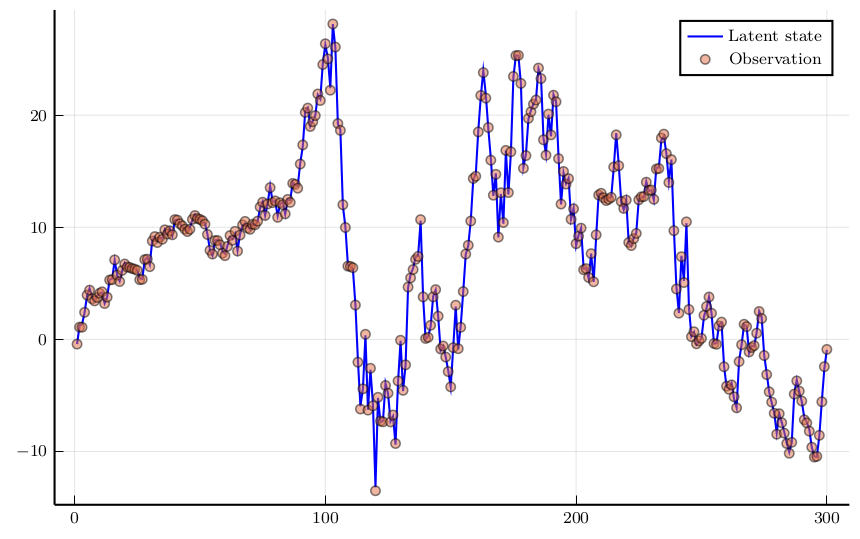

In [6]:
plot(x_true,label="Latent state",legend=:topright,color=:blue)
scatter!(y_data, label="Observation", ms = 3, alpha = 0.5)

In [47]:
savefig("texfiles/HGF_synthetic_data.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/HGF_synthetic_data.svg"

## Exponential node

In [7]:
## Exponential node 
struct ExpNormal end

@node ExpNormal Stochastic [ y, x, z ]   ## f(y,x,z) = NormalMeanPrecision(y| x, exp(z))

@rule ExpNormal(:y, Marginalisation) (q_x::Any, q_z::Any) = begin
    γ1 = approximate_expectation(GenUnscented() ,q_z, (z) -> 1 / exp(z))
    return NormalMeanPrecision(mean(q_x), γ1)
end

@rule ExpNormal(:x, Marginalisation) (q_y::Any, q_z::Any) = begin
    γ1 = approximate_expectation(GenUnscented() ,q_z, (z) -> 1 / exp(z))
    return NormalMeanPrecision(mean(q_y), γ1)
end

@rule ExpNormal(:z, Marginalisation) (q_y::Any, q_x::Any) = begin
    μ_y, v_y = mean_var(q_y)
    μ_x, v_x = mean_var(q_x)

    log_backwardmess = (z) -> -0.5*z - 0.5 * (1/exp(z)) * (μ_y^2 + v_y -2*μ_y * μ_x + μ_x^2 + v_x)
    return ContinuousUnivariateLogPdf(log_backwardmess)
end


@average_energy ExpNormal (q_y::Any, q_x::Any, q_z::Any) = begin
    γ1 = approximate_expectation(GenUnscented() ,q_z, (z) -> 1 / exp(z))
    μ_y, v_y = mean_var(q_y)
    μ_x, v_x = mean_var(q_x)
    μ_z = mean(q_z)
    return 0.5*log(2π) + 0.5*μ_z + 0.5* γ1 * (μ_y^2 + v_y -2*μ_y * μ_x + μ_x^2 + v_x)
end


## Use GCV node

In [ ]:
@model function certain_gcv_hgf(y, z_var, y_var)
    z2_prev ~ NormalMeanVariance(0, 50.)
    z1_prev ~ NormalMeanVariance(0, 50.)
    k ~ NormalMeanVariance(1.,0.01)
    w ~ NormalMeanVariance(0.,0.1)

    for i=1:length(y)
        z2[i] ~ NormalMeanVariance(z2_prev,z_var) #upper layer
        z1[i] ~ GCV(z1_prev, z2[i],k , w) ## lower layer
        y[i] ~ NormalMeanVariance(z1[i], y_var)
        z2_prev = z2[i]
        z1_prev = z1[i]
    end
end

@constraints function hgfconstraints() 
    q(z1, z2, z2_prev, z1_prev,k,w) = q(z1,z1_prev)q(z2,z2_prev)q(w)q(k)
end

@meta function hgfmeta()
    GCV() -> GCVMetadata(GaussHermiteCubature(31)) 
end

@initialization function hgf_init()
    q(z1) = NormalMeanVariance(0,50)
    q(z2) = NormalMeanVariance(0,50)
    q(k) = NormalMeanVariance(1,0.001)
    q(w) = NormalMeanVariance(0,0.01)
end

In [ ]:
GCV_infer = infer(
    model = certain_gcv_hgf(z_var = z_variance, y_var = y_variance,),
    data = (y = y_data,),
    meta = hgfmeta(),
    constraints = hgfconstraints(),
    initialization = hgf_init(),
    iterations = 300,
    returnvars = (z1 = KeepLast(), z2 = KeepLast(),w=KeepLast(),k=KeepLast(),),
    free_energy = true 
)


In [ ]:

qz1_gcv = GCV_infer.posteriors[:z1]
qz2_gcv = GCV_infer.posteriors[:z2]
qw_gcv = GCV_infer.posteriors[:w]
qk_gcv = GCV_infer.posteriors[:k]
;

## Model

In [8]:
@model function gp_HFG1(y, Kuu, z_var, y_var)
    z2_prev ~ NormalMeanVariance(0, 50.)
    z1_prev ~ NormalMeanVariance(0, 50.)
    v ~ MvNormalWeightedMeanPrecision(zeros(size(Kuu,1)), Kuu)
    w ~ GammaShapeRate(0.01,0.01)

    for i=1:length(y)
        z2[i] ~ NormalMeanVariance(z2_prev,z_var) 
        f[i] ~ GPTransition(z2[i],v,w)
        z1[i] ~ ExpNormal(z1_prev, f[i])
        y[i] ~ NormalMeanVariance(z1[i], y_var)
        z2_prev = z2[i]
        z1_prev = z1[i]
    end
end

@meta function meta_gp_HFG1(method,Xu, Kuu_inverse, kernel)
    GPTransition() -> GPTransitionMeta(method,Xu,Kuu_inverse,nothing,kernel,nothing)
end

gp_constraint = @constraints begin
    q(z1,z2,z1_prev,z2_prev,v,w,f) = q(z1)q(z2)q(z1_prev)q(z2_prev)q(v)q(w)q(f)
    q(z1) = q(z1[begin])..q(z1[end])
    q(z2) = q(z2[begin])..q(z2[end])
end
;

In [85]:
Nu = 25; #number of inducing points 
Xu = range(-5.,5;length=Nu);
kernel_gp = 2.26 * with_lengthscale(Matern52Kernel(),3.775) 

Kuu = kernelmatrix(kernel_gp,Xu) + 1e-8*I;
Kuu_inverse = inv(Kuu);

gp_init = @initialization begin
    q(v) = MvNormalWeightedMeanPrecision(zeros(size(Kuu,1)), Kuu)
    q(f) = NormalMeanVariance(0,50.)
    q(z1) = NormalMeanVariance(0,50.)
    q(z2) = NormalMeanVariance(0,50.)
    q(w) = GammaShapeRate(0.01,0.01)
end
;

In [86]:
gp_infer_result = infer(
    model = gp_HFG1(Kuu = Kuu, z_var = z_variance, y_var = y_variance,),
    data = (y = y_data,),
    iterations = 300,
    initialization = gp_init,
    constraints = gp_constraint,
    meta = meta_gp_HFG1(GenUnscented(),Xu,Kuu_inverse,kernel_gp),
    returnvars = (z1 = KeepLast(),z2 = KeepLast(),v = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = true
) 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


Inference results:
  Posteriors       | available for (w, z1, v, z2)
  Free Energy:     | Real[1115.47, 1070.2, 1027.86, 985.188, 944.225, 907.453, 876.981, 853.808, 837.583, 826.972  …  775.312, 775.312, 775.312, 775.313, 775.313, 775.314, 775.314, 775.315, 775.315, 775.316]


In [87]:
qz1_sgp = gp_infer_result.posteriors[:z1]
qz2_sgp = gp_infer_result.posteriors[:z2]
qv_sgp = gp_infer_result.posteriors[:v]
qw_sgp = gp_infer_result.posteriors[:w]
;

## Compare Results

In [88]:
##gp_prediction
function gp_predict(x_test,qv,qw,meta)
    prediction = @call_rule GPTransition(:out, Marginalisation) (q_in=x_test,q_v = qv, q_w = qw, meta=meta)
    return prediction
end

function gcv_predict(upper_state,qk, qw)
    mz, vz = mean_var(upper_state)
    mk, vk = mean_var(qk)
    zk = NormalMeanVariance(mz * mk, mz^2 * vk + mk^2 * vz + vz * vk)
    return @call_rule typeof(+)(:out, Marginalisation) (m_in1=zk, m_in2 = qw)
end

gcv_predict (generic function with 1 method)

In [89]:
gp_predict_mean =[]
gp_predict_var =[]
for i=1:length(qz2_sgp)
    prediction = gp_predict(qz2_sgp[i],qv_sgp,qw_sgp,GPTransitionMeta(GenUnscented(),Xu,Kuu_inverse,nothing,kernel_gp,nothing))
    append!(gp_predict_mean,mean(prediction))
    append!(gp_predict_var,var(prediction)) 
end

gcv_predict_mean =[]
gcv_predict_var =[]
for i=1:length(qz2_gcv)
    prediction = gcv_predict(qz2_gcv[i],qk_gcv,qw_gcv)
    append!(gcv_predict_mean,mean(prediction))
    append!(gcv_predict_var,var(prediction)) 
end

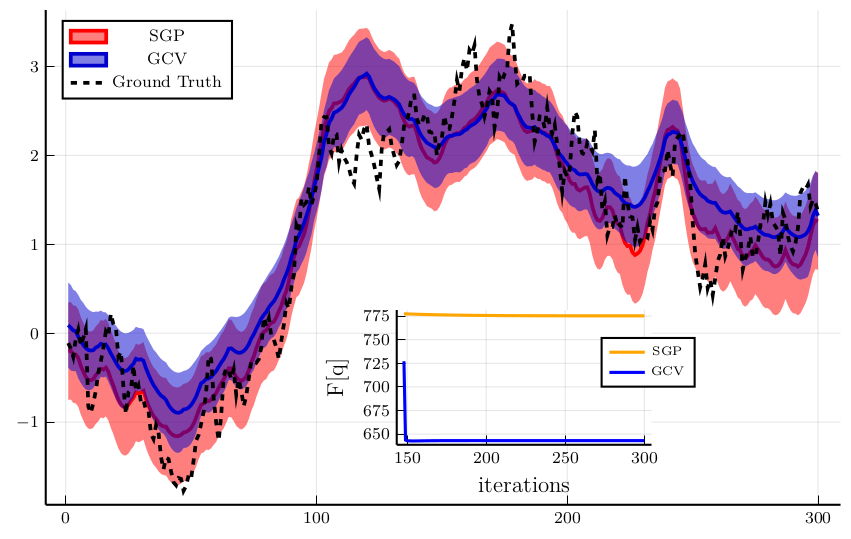

In [90]:
plot(gp_predict_mean, ribbon = sqrt.(gp_predict_var .+ 1e-7),
    lw=1.8,
    label = "SGP",
    color=:red,
    legend=:topleft)
plot!(gcv_predict_mean, ribbon = sqrt.(gcv_predict_var .+ 1e-7),
    lw=1.8,
    label = "GCV",
    color = :mediumblue)
plot!(z_true, label = "Ground Truth", lw=1.8, ls=:dash, c=:black)

plot!([collect(148:300),collect(148:300)],
    [gp_infer_result.free_energy[148:end], GCV_infer.free_energy[148:end]], 
    label=["SGP" "GCV"],
    color=[:orange :blue],
    lw= [1.5 1.5],
    legend_position=(0.8,0.8),
    legend_font_pointsize=6,
    inset = (1, bbox(0.21, 0.1, 0.4, 0.4, :bottom, :right)),
    xlabel="iterations",
    ylabel="F[q]",
    subplot = 2)

In [91]:
savefig("texfiles/HGF_synthetic_comparison.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/HGF_synthetic_comparison.svg"

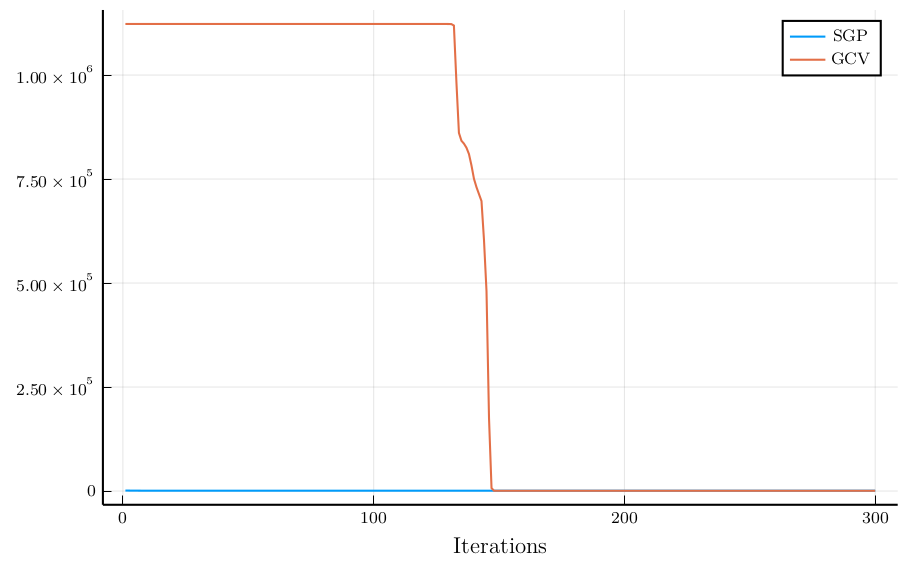

In [92]:
plot(gp_infer_result.free_energy, label="SGP", legend=:topright)
plot!(GCV_infer.free_energy, label="GCV")
xlabel!("Iterations")

## Optimization

In [83]:
kernel_gp_param = (θ) -> θ[1]* with_lengthscale(Matern52Kernel(),θ[2]); 
kernelmatrix_param = (θ) -> kernelmatrix(kernel_gp_param(θ),Xu,Xu);
function my_free_energy(θ)
    @show θ
    my_Kuu = kernelmatrix_param(θ)
    my_Kuu_inverse = inv(my_Kuu)
    my_kernel = kernel_gp_param(θ)
    
    init = @initialization begin
        q(v) = MvNormalWeightedMeanPrecision(zeros(size(my_Kuu,1)), my_Kuu)
        q(f) = NormalMeanVariance(0,50.)
        q(z1) = NormalMeanVariance(0,50.)
        q(z2) = NormalMeanVariance(0,50.)
        q(w) = GammaShapeRate(0.01,0.01)
    end
    infer_result = infer(
        model = gp_HFG1(Kuu = my_Kuu, z_var = z_variance, y_var = y_variance,),
        data = (y = y_data,),
        iterations = 150,
        initialization = init,
        constraints = gp_constraint,
        meta = meta_gp_HFG1(GenUnscented(),Xu,my_Kuu_inverse,my_kernel),
        free_energy = true
    )
    return infer_result.free_energy[end]
end

function learn_params(θ,iter)
    lower = [0.5,0.5]
    upper = [5,5]
    res = optimize((x) -> my_free_energy(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iter))
    return res.minimizer
end

learn_params (generic function with 1 method)

In [84]:
#this'll take ~28min
θ_init = [2.,2.5]
θ_optimal = learn_params(θ_init,1)

θ = [2.0, 2.5]
θ = [3.025, 2.5]
θ = [2.0, 3.775]
θ = [2.0000121109089046, 2.5]
θ = [1.9999878890910952, 2.5]
θ = [2.0, 2.500015138636131]
θ = [2.0, 2.499984861363869]
θ = [2.0, 3.775]
θ = [0.9750000000000001, 3.7750000000000004]
θ = [1.4875, 3.7750000000000004]
θ = [1.4875, 3.7750000000000004]
θ = [2.25625, 3.7750000000000004]
θ = [2.2562500000000005, 1.8624999999999998]
θ = [2.0640625000000004, 2.81875]
θ = [2.16015625, 3.296875]
θ = [2.25625, 3.7750000000000004]
θ = [3.4093750000000003, 3.7750000000000004]
θ = [3.4093750000000003, 1.8624999999999998]
θ = [3.12109375, 2.81875]
θ = [2.8328125, 3.7750000000000004]
θ = [2.25625, 3.7750000000000004]


2-element Vector{Float64}:
 2.25625
 3.7750000000000004